In [1]:
import numpy as np
import seaborn as sns
from scipy.stats import bernoulli, halfnorm, norm, gamma, invgamma, cauchy
import pandas as pd
import matplotlib.pyplot as plt
import math

In [2]:
import pymc as pm
print(f"Running on PyMC v{pm.__version__}")
import aesara.tensor as at
import pytensor.tensor as pt
from scipy.linalg import block_diag, cholesky
import arviz as az

Running on PyMC v5.1.2


In [3]:
# Initialize random number generator
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)

## Simulate data

Simulate data from the following model but include 11 NCOs but no outcome with causal associations with treatment A:

<div>
<img src="dag-1.png" width="500"/>
</div>

Since there is no observed confounder, we can estimate the average causal effects and biases using difference in means or ratios of means. One NCO is excluded from fitting the model to use for checking the posterior predictive.

In [2]:
# Set random seed
np.random.seed(42)
# Set number of observations
n = 100000
# Set number of unobserved confounders
p_u = 1
# Set number of treatment groups
n_a = 3
# Set number of scenarios/treatment contrasts
K = math.comb(n_a, 2)

# Generate latent space regression coefficients of U on A
alpha_u = np.random.uniform(0.25, 0.5, p_u)  # effect of U on treatment assigment A

# Generate unobserved confounder from standard normal
U = np.random.normal(size=(n, p_u))
# Generate another dataset with 1M samples to approximate the truth
U_1m = np.random.normal(size=(1000000, p_u))

# Define the treatment groups by discretizing the latent A according to quantiles
A = np.matmul(U, alpha_u)
# Add observation noise
A = A + np.random.normal(0, 1, size=n)
A_1m = np.matmul(U_1m, alpha_u) + np.random.normal(0, 1, size=len(U_1m))
# Generate the categorical treatment A using a probit model
A_obs = np.digitize(A, np.quantile(A_1m, np.linspace(0, 1, n_a+1))[0:n_a], right=False)
A_obs_1m = np.digitize(A_1m, np.quantile(A_1m, np.linspace(0, 1, n_a+1))[0:n_a], right=False)
# Reindex to start at 0
A_obs -= min(A_obs_1m)
A_obs_1m -= min(A_obs_1m)

# Create one-hot-encoding of A_obs: n \times n_a
unique_values = np.unique(A_obs_1m)
identity_matrix = np.eye(len(unique_values))
A_encoded = identity_matrix[np.searchsorted(unique_values, A_obs)]

In [32]:
# Define number of NCOs
I = 30

# Define the effects of U on the NCOs in latent space
theta_u_low = 0.5
theta_u_high = 1
theta_u = np.random.uniform(theta_u_low, theta_u_high, size=(p_u, I))

# Randomly zero-out the effects
# theta_u *= np.random.choice([0, 1], size=(p_u, I+1))

# Randomly shuffle the sign of the effects with probability 0.5
# theta_u *= np.random.choice([-1, 1], size=(p_u, I+1))

# Generate the latent NCOs
noise_se = 0.1 # larger then estimates deviates more from a parabola curve in figure
N_1m = np.matmul(U_1m, theta_u) + np.random.normal(0, noise_se, size=(len(U_1m), I)) # use large sample of 1M observations to approx true bias
N = np.matmul(U, theta_u) + np.random.normal(0, noise_se, size=(n, I))

# Discretize the latent NCOs
x = np.linspace(0.001, 0.9, I)
h = np.diagonal(np.quantile(N_1m, x, axis=0))
# h = 0
N_obs_1m = 1*(N_1m < h)
N_obs = 1*(N < h)

# Calculate the difference in means or biases
bias_N_true = [] # based on 1M samples
rd_N = []
rr_N = []
for i in range(n_a-1):
    for j in range(i+1, n_a):
        rd_N.append(np.mean(N_obs[A_obs == j,:], axis=0) - np.mean(N_obs[A_obs == i,:], axis=0))
        rr_N.append(np.mean(N_obs[A_obs == j,:], axis=0) / np.mean(N_obs[A_obs == i,:], axis=0))
rd_N = np.array(rd_N).transpose()
rr_N = np.array(rr_N).transpose()
lrr_N = np.log(rr_N)
rr_N

array([[0.23121158, 0.08452474, 0.3655731 ],
       [0.43052234, 0.19664326, 0.45675506],
       [0.49428314, 0.24667039, 0.49904673],
       [0.52616514, 0.2812062 , 0.53444476],
       [0.56548907, 0.31201514, 0.55176157],
       [0.58355387, 0.33622281, 0.57616413],
       [0.60785339, 0.36126719, 0.59433276],
       [0.62639473, 0.38318273, 0.61172726],
       [0.64923049, 0.40118016, 0.61793179],
       [0.67203639, 0.42294275, 0.62934501],
       [0.68526863, 0.44086121, 0.64334072],
       [0.70200172, 0.46639808, 0.6643831 ],
       [0.72374373, 0.47998608, 0.66319894],
       [0.73679902, 0.50317481, 0.68292003],
       [0.75526471, 0.52337226, 0.69296534],
       [0.7670291 , 0.54483561, 0.71031935],
       [0.78496818, 0.5689999 , 0.72487001],
       [0.796221  , 0.58453037, 0.73413081],
       [0.81085127, 0.60728677, 0.74894965],
       [0.82234012, 0.62569013, 0.76086538],
       [0.83744761, 0.65159848, 0.77807671],
       [0.85061668, 0.67238509, 0.7904678 ],
       [0.

In [34]:
x_star = np.array([0.0001, 0.005, 0.05, 0.1, 0.2, 0.3, 0.39, 0.47, 0.58, 0.63, 0.79, 0.85, 0.96])
theta_u_star = np.random.uniform(theta_u_low, theta_u_high, size=(p_u, len(x_star)))
N_latent_star = np.matmul(U, theta_u_star) + np.random.normal(0, noise_se, size=(n, len(x_star)))
h_star = np.diagonal(np.quantile(N_latent_star, x_star, axis=0))
N_star = 1*(N_latent_star < h_star)
# Calculate the difference in means or biases
rd_N_star = []
rr_N_star = []
for i in range(n_a-1):
    for j in range(i+1, n_a):
        rd_N_star.append(np.mean(N_star[A_obs == j,:], axis=0) - np.mean(N_star[A_obs == i,:], axis=0))
        rr_N_star.append(np.mean(N_star[A_obs == j,:], axis=0) / np.mean(N_star[A_obs == i,:], axis=0))
rd_N_star = np.array(rd_N_star).transpose()
rr_N_star = np.array(rr_N_star).transpose()
lrr_N_star = np.log(rr_N_star)
rd_N_star.shape

/var/folders/w9/_ml_c5kd05l3csygdx7k277m0000gn/T/ipykernel_59070/3053714772.py:15: RuntimeWarning: divide by zero encountered in log
  lrr_N_star = np.log(rr_N_star)


(13, 3)

In [35]:
# Define function for statistics: s.e. for the biases
def get_boostrap_rd(indices, ncos, treatment, n):
    b_ncos = ncos[indices, :]
    b_treatment = treatment[indices]
    b_bias = []
    for i in range(n-1):
        for j in range(i+1, n):
            b_bias.append(np.mean(b_ncos[b_treatment==j,:], axis=0) - np.mean(b_ncos[b_treatment==i,:], axis=0))
    return np.array(b_bias).transpose()

def get_boostrap_rr(indices, ncos, treatment, n):
    b_ncos = ncos[indices, :]
    b_treatment = treatment[indices]
    b_bias = []
    for i in range(n-1):
        for j in range(i+1, n):
            b_bias.append(np.mean(b_ncos[b_treatment==j,:], axis=0) / np.mean(b_ncos[b_treatment==i,:], axis=0))
    return np.array(b_bias).transpose()

def get_boostrap_lrr(indices, ncos, treatment, n):
    b_ncos = ncos[indices, :]
    b_treatment = treatment[indices]
    b_bias = []
    for i in range(n-1):
        for j in range(i+1, n):
            b_bias.append(np.mean(b_ncos[b_treatment==j,:], axis=0) / np.mean(b_ncos[b_treatment==i,:], axis=0))
    return np.log(np.array(b_bias).transpose())

# Set the number of bootstrap samples
n_bootstrap = 100
# Create random sample with replacement of row indinces
b_indices = np.random.choice(range(n), size=(n_bootstrap, n), replace=True)
# Apply statistics to bootstrapped samples
b_rd = np.apply_along_axis(get_boostrap_rd, axis=1, arr=b_indices, ncos=N_obs, treatment=A_obs, n=n_a)
b_rr = np.apply_along_axis(get_boostrap_rr, axis=1, arr=b_indices, ncos=N_obs, treatment=A_obs, n=n_a)
b_lrr = np.apply_along_axis(get_boostrap_lrr, axis=1, arr=b_indices, ncos=N_obs, treatment=A_obs, n=n_a)
# Calculate s.e. of statistics in bootstrap samples
se_rd_N = np.std(b_rd, axis=0, ddof=1)
se_rr_N = np.std(b_rr, axis=0, ddof=1)
se_lrr_N = np.std(b_lrr, axis=0, ddof=1)
se_rd_N

array([[0.0003068 , 0.00028215, 0.00016404],
       [0.00143568, 0.0013443 , 0.00099617],
       [0.00199454, 0.00190058, 0.00149914],
       [0.0025637 , 0.00222074, 0.00185056],
       [0.00287038, 0.00243237, 0.00208253],
       [0.0031219 , 0.00286967, 0.00237163],
       [0.00332768, 0.0029587 , 0.00277774],
       [0.00366468, 0.00306256, 0.00304432],
       [0.003498  , 0.00316937, 0.0032513 ],
       [0.00368873, 0.00329605, 0.00339644],
       [0.0039519 , 0.0037519 , 0.00370872],
       [0.00399409, 0.00391774, 0.00407013],
       [0.00375981, 0.00384436, 0.00411096],
       [0.00372854, 0.00372357, 0.00400067],
       [0.00367854, 0.00375854, 0.00423747],
       [0.00388168, 0.00365629, 0.00430645],
       [0.00397614, 0.00365403, 0.00442465],
       [0.00396201, 0.00356484, 0.00433937],
       [0.00379956, 0.00338445, 0.00443422],
       [0.00380519, 0.00348415, 0.00414861],
       [0.00375163, 0.0036236 , 0.0042558 ],
       [0.00418306, 0.00359744, 0.00438415],
       [0.

In [144]:
# Define the correct delta: all zero because U has an effect on each NCO
true_delta = 1*(theta_u[0, :I] == 0)
# True scenario mean bias
# true_beta = np.abs(se_rd_N[:I,][true_delta==0,]).mean(axis=0)
# Define the correct M: sign of the effect of U on NCOs
true_M = (np.sign(theta_u[:,:I]) + 1) // 2
true_M = true_M.reshape((I,))
print(true_delta.mean())
print(true_M.mean())
# print(true_beta)

0.0
1.0


In [36]:
# Convert matrix of biases to dataframe
data_columns = ['setting_' + str(i) for i in range(K)]
data_index = ['nco_' + str(i) for i in range(I)]
data = pd.DataFrame(rd_N, columns=data_columns)
data['nco'] = data_index
data_long = pd.melt(data,
                    id_vars=['nco'],
                    value_vars=data_columns, 
                    var_name='setting', value_name='rd')
data_long['se_rd'] = se_rd_N.flatten('F')
data_long['se_rr'] = se_rr_N.flatten('F')
data_long['se_lrr'] = se_lrr_N.flatten('F')
data_long['rr'] = rr_N.flatten('F')
data_long['lrr'] = lrr_N.flatten('F')
data_long['prevalence'] = np.tile(np.linspace(0.05, 0.9, I), K)
print(data_long.head(3))

     nco    setting        rd     se_rd     se_rr    se_lrr        rr  \
0  nco_0  setting_0 -0.002189  0.000307  0.052384  0.228042  0.231212   
1  nco_1  setting_0 -0.034247  0.001436  0.015402  0.035534  0.430522   
2  nco_2  setting_0 -0.055337  0.001995  0.013117  0.026483  0.494283   

        lrr  prevalence  
0 -1.464422    0.050000  
1 -0.842756    0.079310  
2 -0.704647    0.108621  


/var/folders/w9/_ml_c5kd05l3csygdx7k277m0000gn/T/ipykernel_59070/659306573.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['NCO ' + str(i+1) for i in range(I)])
/var/folders/w9/_ml_c5kd05l3csygdx7k277m0000gn/T/ipykernel_59070/659306573.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['NCO ' + str(i+1) for i in range(I)])


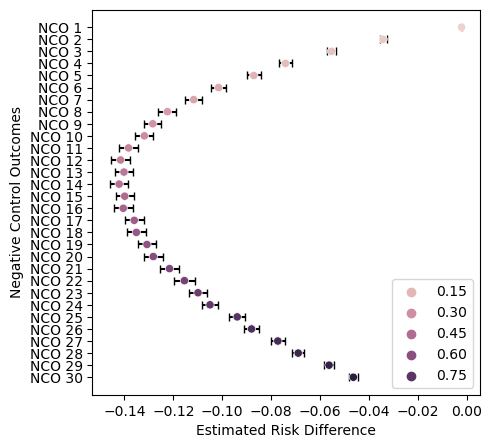

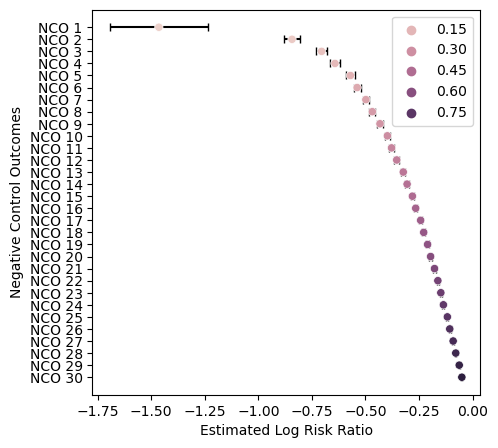

In [39]:
tmp_df = data_long[data_long.setting == "setting_0"]
fig, ax = plt.subplots(figsize=(5,5))
fig.canvas.draw()
sns.scatterplot(data=tmp_df, x='rd', y='nco', hue='prevalence')
ax.errorbar(x=tmp_df.rd, y=tmp_df.nco, xerr=tmp_df.se_rd, fmt='none', ecolor='black', capsize=3, zorder=0)
ax.set_yticklabels(['NCO ' + str(i+1) for i in range(I)])
plt.xlabel('Estimated Risk Difference')
plt.ylabel('Negative Control Outcomes')
plt.legend();
plt.savefig("/Users/phucnguyen/Documents/duke/nco/nco/figures/sim-res-biased085.pdf", format="pdf", bbox_inches="tight")

fig, ax = plt.subplots(figsize=(5,5))
fig.canvas.draw()
sns.scatterplot(data=tmp_df, x='lrr', y='nco', hue='prevalence')
ax.errorbar(x=tmp_df.lrr, y=tmp_df.nco, xerr=tmp_df.se_lrr, fmt='none', ecolor='black', capsize=3, zorder=0)
ax.set_yticklabels(['NCO ' + str(i+1) for i in range(I)])
plt.xlabel('Estimated Log Risk Ratio')
plt.ylabel('Negative Control Outcomes')
plt.legend();

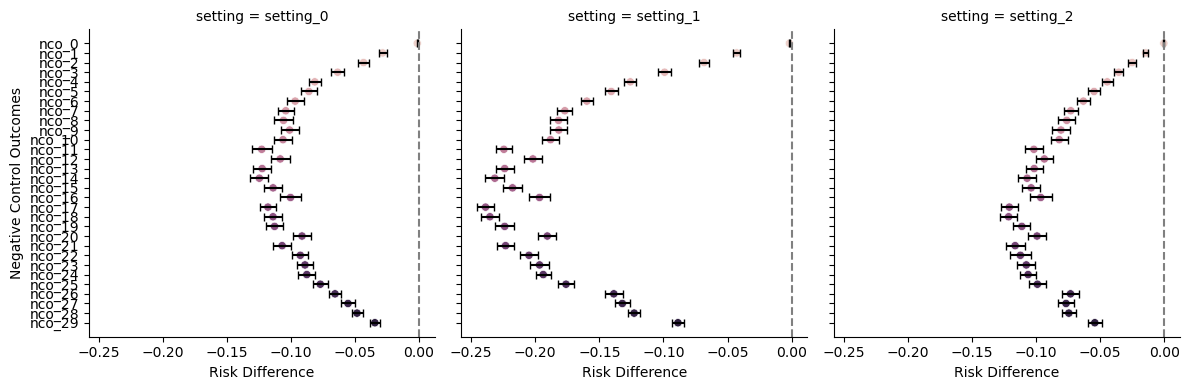

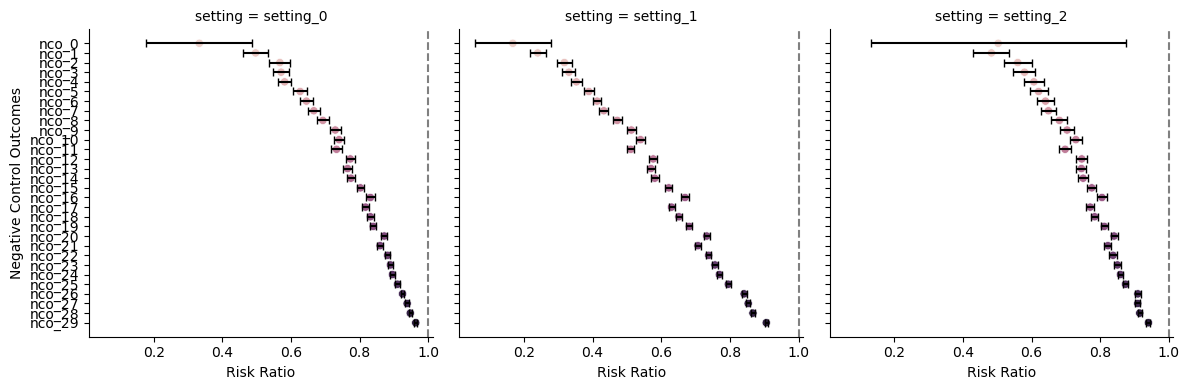

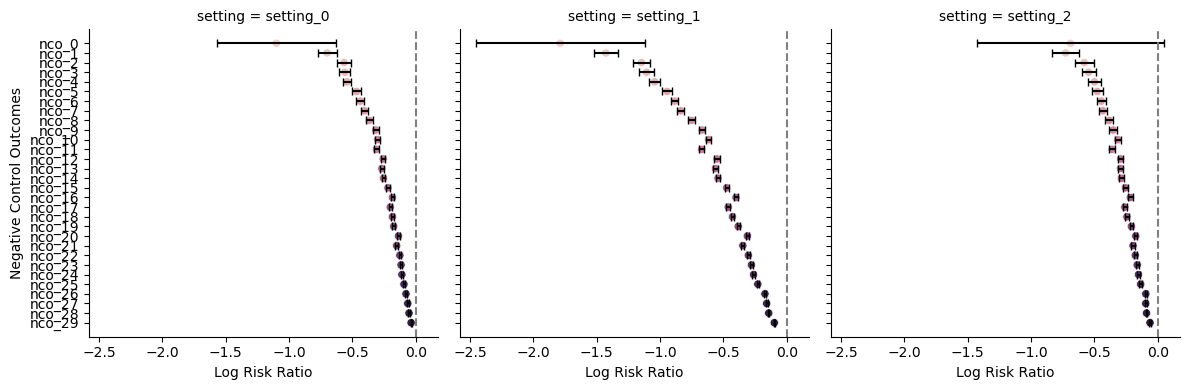

In [146]:
for col, title in zip(['rd', 'rr', 'lrr'], ['Risk Difference', 'Risk Ratio', 'Log Risk Ratio']):
    # Initialize a facet grid plot
    g = sns.FacetGrid(data_long, col='setting', height=4, aspect=1)

    # Create the scatter plot of the simulated data
    g.map(sns.scatterplot, col, 'nco', 'prevalence', alpha=1)

    # Function to add error bars
    def add_error_bars(x, y, error, **kwargs):
        data = kwargs.pop("data")
        ax = plt.gca()
        for i, (_, row) in enumerate(data.iterrows()):
            ax.errorbar(row[col], row['nco'], xerr=1.96*row['se_'+col], 
                        fmt='none', ecolor='black', capsize=3)

    # Add error bars faceted by 'type'
    g.map_dataframe(add_error_bars, 'bias', 'nco', 'se')

    # Add verticle line at 0.0
    if col=='rr':
        g.refline(x=1.0)
    else:
        g.refline(x=0.0)

    # Change x axis label
    g.set_axis_labels(title, "Negative Control Outcomes")

    # Show the plot
    plt.show()

If outcomes are dependent, needs to inflate the variance. Add grouping to the outcomes.

# Real data

Use LOOV, fit the model on all but one NCO and does posterior predictive on that NCO. Average the number of times posterior predictive covers the observed bias.

Use study where we purposefully leave out an important predictor so that we can estimate the true bias.

# Model defintion

## I. One scenario

$$
S_{i} &= \delta_i \mathbb{I}(0) + (1-\delta_i) (2M_i - 1) \mu(x_i) \\
\mu &\sim GP(0, K)\\
K_{hk} &= k(x_h, x_k) = \sigma^2 e^{-\frac{(x_h - x_k)^2}{2 l^2 }}
$$

In [317]:
def run_gp_m_one(ate, se, x,
                     sample, tune, chain,
                     phi_d=None, phi_m=None, 
                     alpha_d=1, beta_d=1, alpha_m=1, beta_m=1,
                     x_star=None,
                     random_seed=123, 
                     target_accept=0.8, cores=1
                    ):
    # Set the number of NCOs
    I = ate.shape[0]
    
    # Set the number of scenarios/treatment contrasts
    K = ate.shape[1]

    # Declare the dimensions of the data and parameters. 
    # This helps with organizing the indices of the posterior samples
    coords_nco = ['nco_'+str(i) for i in range(I)]
    coords_setting = ['setting_'+str(i) for i in range(K)]
    coords = {'nco': coords_nco, 'setting': coords_setting}
    
    # Initialize a model
    model = pm.Model(coords=coords)
    with model:
        
        # State input data as shared variables. Not sure if this is neccesary, but seems to be recommended in the documentation
        Y_t = pm.MutableData('Y', ate, dims=('nco', 'setting'))
        # TODO: update to take a covariance matrix as input. Here, it takes a vector of variances as input
        Sigma_t = pm.MutableData('Sigma', se, dims=('nco', 'setting'))
        x_t = pm.MutableData('x', x, dims=('nco', 'probability')) # currently a vector of outcome probabilities

        # Priors for unknown model parameters
        # phi_d: probability of having zero bias
        if phi_d is None: 
            phi_d = pm.Beta('phi_d', alpha=alpha_d, beta=beta_d)
        # phi_m: probability of having a positive bias
        if phi_m is None: 
            phi_m = pm.Beta('phi_m', alpha=alpha_m, beta=beta_m)
        # For one scenario: model the mean function as GP with square exponential kernel
        # ls: lengthscale controls wiggliness of mean function
        ls = pm.InverseGamma('ls', mu=1, sigma=10)
        # sigma: controls magnitude of mean function
        sigma = pm.Gamma('sigma', mu=1, sigma=10)
        # define a GP prior and its covariance
        gp_m = pm.gp.Latent(cov_func=sigma * pm.gp.cov.ExpQuad(input_dim=1, ls=ls))
        # assign the GP prior to observations
        m = gp_m.prior('m', x_t, dims='nco', jitter=1e-7)
        
        # sample indicator of a zero bias
        delta = pm.Bernoulli('delta', p=phi_d, size=I, dims='nco')
        # sample indicator of a positive bias
        M = pm.Bernoulli('M', p=phi_m, size=I, dims='nco')
        # Important: all scenarios will have one mu(x), aka the same mean
        mu = pm.Deterministic('mu', 
                                pt.outer((1-delta)*(2*M-1)*m, pt.ones(K)), 
                                dims=('nco', 'setting'))

        # Likelihood model
        # TODO: make this a truncated likelihood -2 to 2?
        Y_obs = pm.Normal('Y_obs', mu=mu, sigma=Sigma_t, observed=Y_t, dims=('nco', 'setting'))
        
        # Sample posteriors
        trace = pm.sample(sample, tune=tune, chains=chain, 
                          target_accept=target_accept, random_seed=random_seed, cores=cores)
        
        # Sample posterior predictive
        if x_star is not None:
            m_star = gp_m.conditional('m_star', x_star, jitter=1e-4)
            ppc = pm.sample_posterior_predictive(trace, var_names=['m_star'])
            trace.extend(ppc)

    return (model, trace)

In [316]:
def run_gp_one(ate, se, x,
                     sample, tune, chain,
                     phi_d=None, phi_m=None, 
                     alpha_d=1, beta_d=1, alpha_m=1, beta_m=1,
                     x_star=None,
                     random_seed=123, 
                     target_accept=0.8, cores=1
                    ):
    # Set the number of NCOs
    I = ate.shape[0]
    
    # Set the number of scenarios/treatment contrasts
    K = ate.shape[1]

    # Declare the dimensions of the data and parameters. 
    # This helps with organizing the indices of the posterior samples
    coords_nco = ['nco_'+str(i) for i in range(I)]
    coords_setting = ['setting_'+str(i) for i in range(K)]
    coords = {'nco': coords_nco, 'setting': coords_setting}
    
    # Initialize a model
    model = pm.Model(coords=coords)
    with model:
        
        # State input data as shared variables. Not sure if this is neccesary, but seems to be recommended in the documentation
        Y_t = pm.MutableData('Y', ate, dims=('nco', 'setting'))
        # TODO: update to take a covariance matrix as input. Here, it takes a vector of variances as input
        Sigma_t = pm.MutableData('Sigma', se, dims=('nco', 'setting'))
        x_t = pm.MutableData('x', x, dims=('nco', 'probability')) # currently a vector of outcome probabilities

        # Priors for unknown model parameters
        # phi_d: probability of having zero bias
        if phi_d is None: 
            phi_d = pm.Beta('phi_d', alpha=alpha_d, beta=beta_d)
        # phi_m: probability of having a positive bias
        if phi_m is None: 
            phi_m = pm.Beta('phi_m', alpha=alpha_m, beta=beta_m)
        # For one scenario: model the mean function as GP with square exponential kernel
        # ls: lengthscale controls wiggliness of mean function
        ls = pm.InverseGamma('ls', mu=1, sigma=10)
        # sigma: controls magnitude of mean function
        sigma = pm.Gamma('sigma', mu=1, sigma=10)
        # define a GP prior and its covariance
        gp_m = pm.gp.Latent(cov_func=sigma * pm.gp.cov.ExpQuad(input_dim=1, ls=ls))
        # assign the GP prior to observations
        m = gp_m.prior('m', x_t, dims='nco', jitter=1e-7)
        
        # For one scenario: model the variance as a GP with square exponential kernel
        # ls: lengthscale controls wiggliness of variance function
        ls_v = pm.InverseGamma('ls_v', mu=1, sigma=10)
        # sigma: controls magnitude of variance function
        sigma_v = pm.Gamma('sigma_v', mu=1, sigma=10)
        # define a GP prior and its covariance
        gp_v = pm.gp.Latent(cov_func=sigma_v * pm.gp.cov.ExpQuad(input_dim=1, ls=ls_v))
        # assign the GP prior to observations
        log_v = gp_v.prior('log_v', x_t, dims='nco', jitter=1e-7)
        v = pm.Deterministic("v", pm.math.exp(log_v))
        
        # sample indicator of a zero bias
        delta = pm.Bernoulli('delta', p=phi_d, size=I, dims='nco')
        # sample indicator of a positive bias
        M = pm.Bernoulli('M', p=phi_m, size=I, dims='nco')
        # composite of m and v
        f = pm.Normal('f', mu=m, sigma=v, dims='nco')
        # Important: all scenarios will have one mu(x), aka the same mean
        mu = pm.Deterministic('mu', 
                                pt.outer((1-delta)*(2*M-1)*f, pt.ones(K)), 
                                dims=('nco', 'setting'))

        # Likelihood model
        # TODO: make this a truncated likelihood -2 to 2?
        Y_obs = pm.Normal('Y_obs', mu=mu, sigma=Sigma_t, observed=Y_t, dims=('nco', 'setting'))
        
        # Sample posteriors
        trace = pm.sample(sample, tune=tune, chains=chain, 
                          target_accept=target_accept, random_seed=random_seed, cores=cores)
        
        # Sample posterior predictive
        if x_star is not None:
            m_star = gp_m.conditional('m_star', x_star, jitter=1e-4)
            log_v_star = gp_v.conditional('log_v_star', x_star, jitter=1e-3)
            v_star = pm.Deterministic('v_star', pm.math.exp(log_v_star))
            f_star = pm.Normal('f_star', mu=m_star, sigma=v_star)
            ppc = pm.sample_posterior_predictive(trace, var_names=['m_star', 'log_v_star', 'v_star', 'f_star'])
            trace.extend(ppc)

    return (model, trace)

In [4]:
5 // 2

2

In [339]:
def add_index(x):
    return np.hstack([np.tile(x, (2, 1)), np.vstack([np.zeros(x.shape), np.ones(x.shape)])])

def run_gp_lmc_one(ate, se, x,
                 sample, tune, chain,
                 phi_d=None, phi_m=None, 
                 alpha_d=1, beta_d=1, alpha_m=1, beta_m=1,
                 x_star=None,
                 R=2, # rank of B
                 random_seed=123, 
                 target_accept=0.8, cores=1
                    ):
    # Set the number of NCOs
    I = ate.shape[0]
    
    # Set the number of scenarios/treatment contrasts
    K = ate.shape[1]

    # Declare the dimensions of the data and parameters. 
    # This helps with organizing the indices of the posterior samples
    coords_nco = ['nco_'+str(i) for i in range(I)]
    coords_setting = ['setting_'+str(i) for i in range(K)]
    coords = {'nco': coords_nco, 'setting': coords_setting}
    
    # Initialize a model
    model = pm.Model(coords=coords)
    with model:
        
        # State input data as shared variables. Not sure if this is neccesary, but seems to be recommended in the documentation
        Y_t = pm.MutableData('Y', ate, dims=('nco', 'setting'))
        # TODO: update to take a covariance matrix as input. Here, it takes a vector of variances as input
        Sigma_t = pm.MutableData('Sigma', se, dims=('nco', 'setting'))
        x_t = pm.MutableData('x', x, dims=('nco', 'probability')) # currently a vector of outcome probabilities

        # Priors for unknown model parameters
        # phi_d: probability of having zero bias
        if phi_d is None: 
            phi_d = pm.Beta('phi_d', alpha=alpha_d, beta=beta_d)
        # phi_m: probability of having a positive bias
        if phi_m is None: 
            phi_m = pm.Beta('phi_m', alpha=alpha_m, beta=beta_m)
        
        # For one scenario: model the mean function as GP with square exponential kernel
        # ls: lengthscale controls wiggliness of mean function
        ls = pm.InverseGamma('ls', mu=1, sigma=10)
        # sigma: controls magnitude of mean function
        sigma = pm.Gamma('sigma', mu=1, sigma=10)
        # define within output covariance
        eqcov = sigma * pm.gp.cov.ExpQuad(input_dim=1, active_dims=[0], ls=ls)
        # define the low rank representation of the covariance between outputs
        D = 2 # two outputs: mean and variance
        W = pm.Normal("W", mu=0, sigma=10, shape=(D, R))
        coreg = pm.gp.cov.Coregion(input_dim=1, active_dims=[0], kappa=np.repeat(1e-4, D), W=W)
        # define a kronecker covariance
        cov = pm.gp.cov.Kron([eqcov, coreg])
        # define a GP
        gp = pm.gp.Latent(cov_func=cov)
        # assign the GP prior to observations
        mv = gp.prior('mv', add_index(x), jitter=1e-7)
        m = mv[:len(x)]
        log_v = mv[len(x):]
        v = pm.Deterministic("v", pm.math.exp(log_v))
        
        # sample indicator of a zero bias
        delta = pm.Bernoulli('delta', p=phi_d, size=I, dims='nco')
        # sample indicator of a positive bias
        M = pm.Bernoulli('M', p=phi_m, size=I, dims='nco')
        # composite of m and v
        f = pm.Normal('f', mu=m, sigma=v, dims='nco')
        # Important: all scenarios will have one mu(x), aka the same mean
        mu = pm.Deterministic('mu', 
                                pt.outer((1-delta)*(2*M-1)*f, pt.ones(K)), 
                                dims=('nco', 'setting'))

        # Likelihood model
        # TODO: make this a truncated likelihood -2 to 2?
        Y_obs = pm.Normal('Y_obs', mu=mu, sigma=Sigma_t, observed=Y_t, dims=('nco', 'setting'))
        
        # Sample posteriors
        trace = pm.sample(sample, tune=tune, chains=chain, 
                          target_accept=target_accept, random_seed=random_seed, cores=cores)
        
        # Sample posterior predictive
        if x_star is not None:
            mv = gp.conditional('mv_star', add_index(x_star), jitter=1e-4)
            ppc = pm.sample_posterior_predictive(trace, var_names=['mv_star'])
            trace.extend(ppc)

    return (model, trace)

#### Fit model

In [319]:
# Homoskedastic GP
x_star = np.array([0.0001, 0.005, 0.05, 0.1, 0.2, 0.3, 0.39, 0.47, 0.58, 0.63, 0.79, 0.85, 0.96])
model_1, trace_1 = run_gp_m_one(rd_N[:, 0, None], 
                              se_rd_N[:, 0, None],
                              x = x.reshape(-1, 1),
                              phi_d = 0, phi_m = 0, # to remove non-identifiability
                              sample = 1000, tune = 1000, chain = 1,
                              x_star = x_star.reshape(-1, 1),
                              random_seed=RANDOM_SEED, target_accept=0.95, cores=2
                             )
# ERROR: Initial evaluation of model at starting point failed!
# ==> SOLUTION: sample predictive distribution within the same scope random variables are defined
# ISSUE: Extremely wide predictive CI
# ==> BUG: pm.sample_posterior_predictive(trace.posterior, var_names=['f_star']) should use "trace" instead of "trace.posterior"
# ISSUE: Predictive CI widest at the boundaries (0, 1) and constant across x between 0, 1
#        Want CI to taper at the boundaries.
# ==> TRY: GP of variance: sigma ~ Gamma, ls ~ InverseGamma gives much better results than sigma ~ InverseGamma, ls ~ Gamma

Sequential sampling (1 chains in 1 job)
CompoundStep
>NUTS: [ls, sigma, m_rotated_]
>BinaryGibbsMetropolis: [delta, M]


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 423 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Sampling: [m_star]


In [321]:
# Heteroskedastic GP
model_2, trace_2 = run_gp_one(rd_N[:, 0, None], 
                              se_rd_N[:, 0, None],
                              x = x.reshape(-1, 1),
                              phi_d = 0, phi_m = 0, # to remove non-identifiability
                              sample = 1000, tune = 1000, chain = 1,
                              x_star = x_star.reshape(-1, 1),
                              random_seed=RANDOM_SEED, target_accept=0.95, cores=2
                             )

Sequential sampling (1 chains in 1 job)
CompoundStep
>NUTS: [ls, sigma, m_rotated_, ls_v, sigma_v, log_v_rotated_, f]
>BinaryGibbsMetropolis: [delta, M]


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 739 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Sampling: [f_star, log_v_star, m_star]


In [343]:
# Heteroskedastic GP with covariance between mean function and variance function
model_3, trace_3 = run_gp_lmc_one(
    rd_N[:, 0, None], 
    se_rd_N[:, 0, None],
    x = x.reshape(-1, 1),
    phi_d = 0, phi_m = 0, # to remove non-identifiability
    sample = 1000, tune = 10000, chain = 1,
    x_star = x_star.reshape(-1, 1),
    random_seed=RANDOM_SEED, target_accept=0.95, cores=2
    )

Sequential sampling (1 chains in 1 job)
CompoundStep
>NUTS: [ls, sigma, W, mv_rotated_, f]
>BinaryGibbsMetropolis: [delta, M]


Sampling 1 chain for 10_000 tune and 1_000 draw iterations (10_000 + 1_000 draws total) took 4990 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Sampling: [mv_star]


#### Show posterior diagnostics

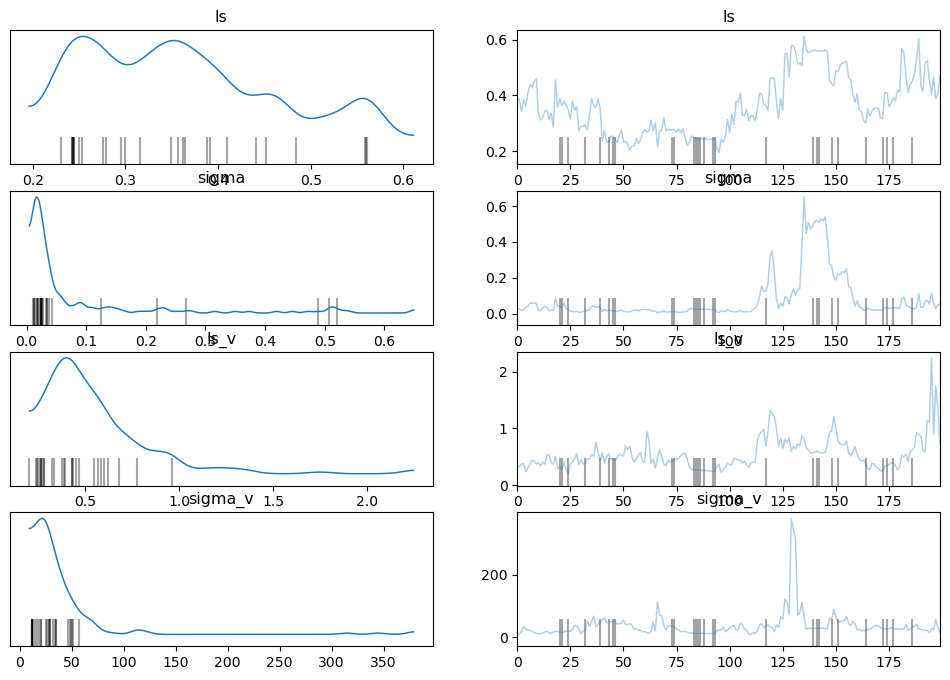

In [284]:
az.plot_trace(trace_1, var_names=['ls', 'sigma', 'ls_v', 'sigma_v']);

#### Show posterior predictive distribution

In [ ]:
# plot the samples from the gp posterior with samples and shading
from pymc.gp.util import plot_gp_dist

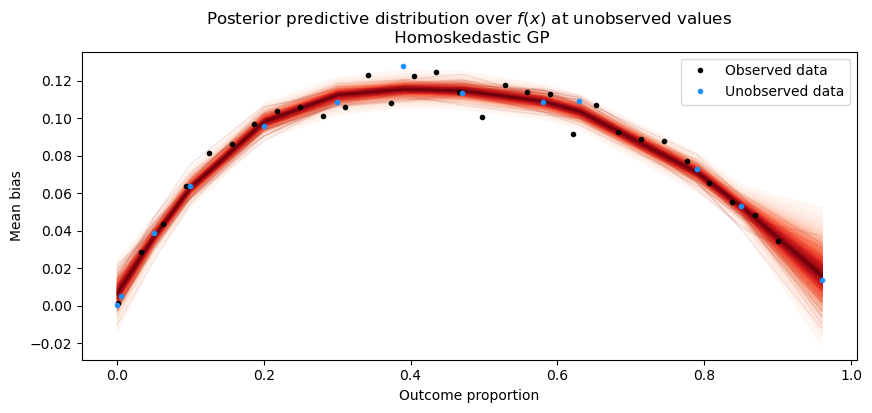

In [379]:
# plot the results
fig = plt.figure(figsize=(10, 4))
ax = fig.gca()

f_star = az.extract(trace_1.posterior_predictive, var_names='m_star').transpose("sample", ...)
plot_gp_dist(ax, f_star, x_star)

# plot the data and the true latent function
ax.plot(x, -rd_N[:, 0], "ok", ms=3, label="Observed data")
# plot the unobserved data
ax.plot(x_star, -rd_N_star[:, 0], "o", color='dodgerblue', ms=3, label="Unobserved data")

# axis labels and title
plt.xlabel("Outcome proportion")
plt.ylabel("Mean bias")
plt.title("Posterior predictive distribution over $f(x)$ at unobserved values\n Homoskedastic GP")
plt.legend();

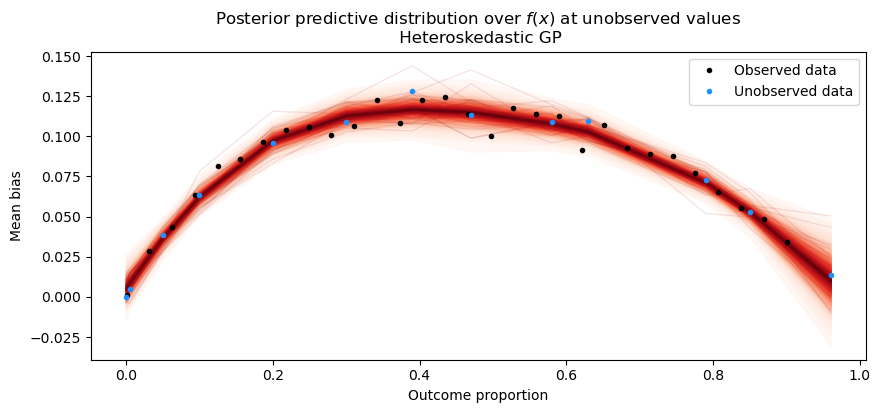

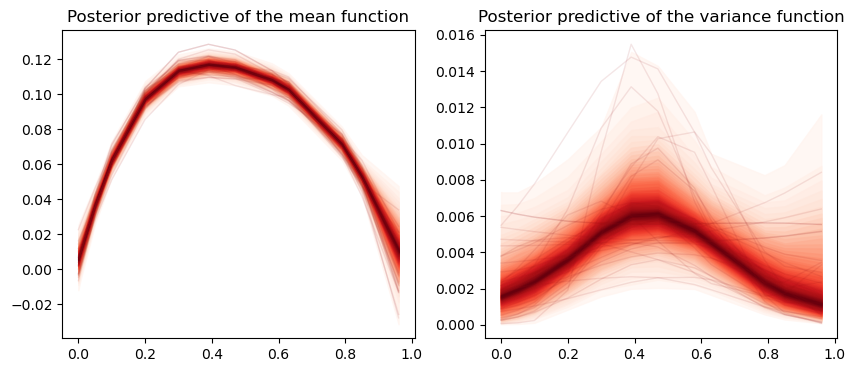

In [378]:
# plot the posterior predictive
fig = plt.figure(figsize=(10, 4))
ax = fig.gca()
f_star = az.extract(trace_2.posterior_predictive, var_names='f_star').transpose("sample", ...)
plot_gp_dist(ax, f_star, x_star)
# plot the data and the true latent function
ax.plot(x, -rd_N[:, 0], "ok", ms=3, label="Observed data")
# plot the unobserved data
ax.plot(x_star, -rd_N_star[:, 0], "o", color='dodgerblue', ms=3, label="Unobserved data")
# axis labels and title
plt.xlabel("Outcome proportion")
plt.ylabel("Mean bias")
plt.title("Posterior predictive distribution over $f(x)$ at unobserved values\n Heteroskedastic GP")
plt.legend();

# Plot the posterior of the GP mean and GP variance
m_ppc = az.extract(trace_2.posterior_predictive, var_names='m_star').transpose("sample", ...)
v_ppc = az.extract(trace_2.posterior_predictive, var_names='v_star').transpose("sample", ...)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
plot_gp_dist(ax1, m_ppc, x_star)
plot_gp_dist(ax2, v_ppc, x_star)
ax1.set_title('Posterior predictive of the mean function')
ax2.set_title('Posterior predictive of the variance function')
plt.show();

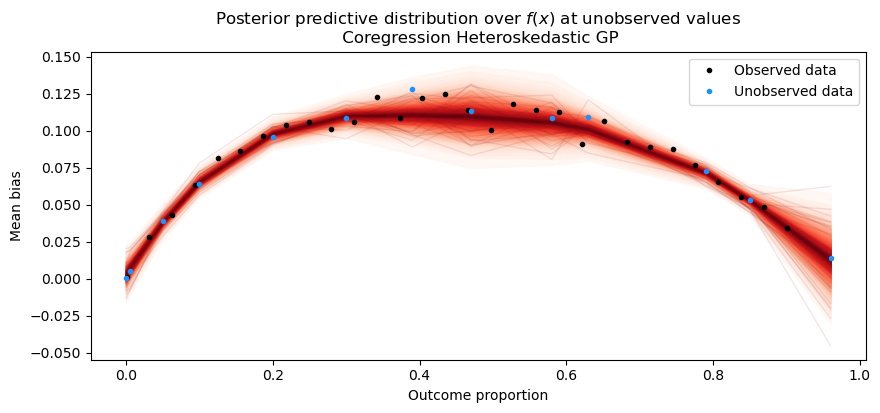

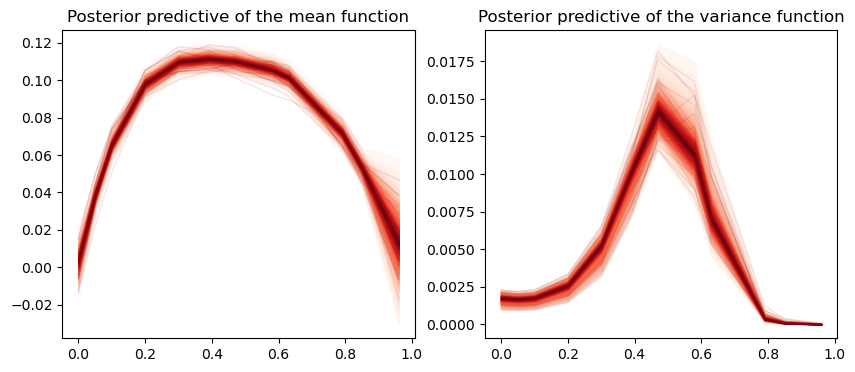

In [377]:
# plot the posterior predictive
fig = plt.figure(figsize=(10, 4))
ax = fig.gca()
# get posterior predictive
mv_ppc = az.extract(trace_3.posterior_predictive, var_names='mv_star').transpose("sample", ...)
m_ppc = mv_ppc[:, :len(x_star)]
log_v_ppc = mv_ppc[:, len(x_star):]
f_ppc = norm.rvs(m_ppc, np.exp(log_v_ppc))
plot_gp_dist(ax, f_ppc, x_star)
# plot the observed data
ax.plot(x, -rd_N[:, 0], "ok", ms=3, label="Observed data")
# plot the unobserved data
ax.plot(x_star, -rd_N_star[:, 0], "o", color='dodgerblue', ms=3, label="Unobserved data")
# axis labels and title
plt.xlabel("Outcome proportion")
plt.ylabel("Mean bias")
plt.title("Posterior predictive distribution over $f(x)$ at unobserved values\n Coregression Heteroskedastic GP")
plt.legend();

# Plot the posterior of the GP mean and GP variance
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
plot_gp_dist(ax1, m_ppc, x_star)
plot_gp_dist(ax2, np.exp(log_v_ppc), x_star)
ax1.set_title('Posterior predictive of the mean function')
ax2.set_title('Posterior predictive of the variance function')
plt.show();

In [380]:
# Check correlation between mean function and covariance function
# W = az.extract(trace_3, var_names='W').transpose("sample", ...).data
# W_T = np.swapaxes(W, 1, 2)
# WW_T = np.matmul(W, W_T)
# B = WW_T.mean(axis=0)
# std_deviations = np.sqrt(np.diag(B))
# B / np.outer(std_deviations, std_deviations)
W.mean(axis=0)

array([[ -3.44872958,   2.0326931 ],
       [-10.04116635, -33.08111587]])

## II. Multiple Scenarios

In [56]:
# Remove constraints that beta is non-negative so the sampler explores the space
# more efficiently and removes divergences in Hamiltonian MC
# Post-process: 
#      m_ik = ((2m_i-1)*sign(beta_k) + 1) / 2
#      beta_k = abs(beta_k)

# ate: I \times K matrix of ATE estimates
# se: I \times K matrix of s.e. of the ATE estimates
# phi_d, phi_m: Empirical Bayes estimates of phi_d, phi_m; if None places hierarchical priors on them
# TODO: update code to take se as covariance matrix inputs
def get_model_gp(ate, se, x=None, phi_d=None, phi_m=None, 
                            nu=None, tau=None, 
                            alpha_d=1, beta_d=1, alpha_m=1, beta_m=1,
                            alpha_sigma=0.001, beta_sigma=0.001,
                            x_star=None
                           ):
    # Set the number of NCOs
    I = ate.shape[0]
    
    # Set the number of scenarios/treatment contrasts
    K = ate.shape[1]

    # Declare the dimensions of the data and parameters. 
    # This helps with organizing the indices of the posterior samples
    coords_nco = ['nco_'+str(i) for i in range(I)]
    coords_setting = ['setting_'+str(i) for i in range(K)]
    coords = {'nco': coords_nco, 'setting': coords_setting}
    
    # Initialize a model
    model = pm.Model(coords=coords)
    with model:
        
        # State input data as shared variables. Not sure if this is neccesary, but seems to be recommended in the documentation
        Y_t = pm.MutableData('Y', ate, dims=('nco', 'setting'))
        Sigma_t = pm.MutableData('Sigma', se, dims=('nco', 'setting')) # TODO: update to include covariances
        x_t = pm.MutableData('x', x, dims=('nco', 'probability')) # currently a vector of outcome probabilities
        if x_star is not None:
            x_star_t = pm.MutableData('x_star', x_star, dims=('nco', 'probability')) # a vector of new outcome probabilities

        # Priors for unknown model parameters
        if phi_d is None: 
            phi_d_t = pm.Beta('phi_d', alpha=alpha_d, beta=beta_d)
        else:
            phi_d_t = phi_d
        if phi_m is None: 
            phi_m_t = pm.Beta('phi_m', alpha=alpha_m, beta=beta_m)
        else:
            phi_m_t = phi_m
        ls = pm.Gamma('ls', mu=1, sigma=10)
        sigma_t = pm.InverseGamma('sigma', mu=1, sigma=10)
        latent = pm.gp.Latent(cov_func=pm.gp.cov.ExpQuad(input_dim=1, ls=ls),)
        f_t = latent.prior('f', x_t, dims='nco', jitter=1e-7)
#         f_t = [latent.prior('f'+str(k), x_t, dims='nco', jitter=1e-7) for k in range(K)] # jitter for numerical stability
        beta_t = pm.MvNormal('beta', mu=pt.sqrt(sigma_t)*f_t, cov=pt.eye(I), size=K, dims=('setting', 'nco'))
        delta_t = pm.Bernoulli('delta', p=phi_d_t, size=I, dims='nco')
        m_t = pm.Bernoulli('m', p=phi_m_t, size=I, dims='nco')
        mu_t = pm.Deterministic('mu', 
                                pt.outer((1-delta_t)*(2*m_t-1), pt.ones(K))*beta_t.T, 
                                dims=('nco', 'setting'))

        # Likelihood model
        Y_obs = pm.Normal('Y_obs', mu=mu_t, sigma=Sigma_t, observed=Y_t, dims=('nco', 'setting'))
        
    return model

In [57]:
model = get_model_gp(rd_N, se_rd_N, 
                     x = x.reshape(-1, 1),
                     alpha_d=1, beta_d=10, alpha_m=10, beta_m=1)
n_samples = 200
n_tune = 190
n_chains = 1
with model:
    # MCMC sampling
    trace = pm.sample(n_samples, tune=n_tune, chains=n_chains, 
                      target_accept=0.9, random_seed=RANDOM_SEED)

Only 200 samples in chain.
Sequential sampling (1 chains in 1 job)
CompoundStep
>NUTS: [phi_d, phi_m, ls, sigma, f_rotated_, beta]
>BinaryGibbsMetropolis: [delta, m]


Sampling 1 chain for 190 tune and 200 draw iterations (190 + 200 draws total) took 19 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


In [77]:
model_lrr = get_model_unconstrained(lrr_N, se_lrr_N, 
                                x = x.reshape(-1, 1),
                                alpha_d=1, beta_d=10, alpha_m=10, beta_m=1)
with model_lrr:
    # MCMC sampling
    trace_lrr = pm.sample(20000, tune=19000, chains=1, 
                      target_accept=0.9, random_seed=RANDOM_SEED)

Sequential sampling (1 chains in 1 job)
CompoundStep
>NUTS: [phi_d, phi_m, ls, f_rotated_, sigma, beta]
>BinaryGibbsMetropolis: [delta, m]


Sampling 1 chain for 19_000 tune and 20_000 draw iterations (19_000 + 20_000 draws total) took 708 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


In [13]:
num_samps = 1000
samps = az.extract(trace, var_names=['beta'], num_samples=num_samps).to_dataframe()
samps = samps.drop(['draw', 'chain'], axis=1)
samps = samps.reset_index()
samps = samps.groupby(['setting', 'nco'], as_index=False).agg(
    low=('beta', lambda x: - np.quantile(np.abs(x), 0.025)),
    avg=('beta', lambda x: - np.abs(x).mean()),
    high=('beta', lambda x: - np.quantile(np.abs(x), 0.975))
)
samps_data = pd.merge(data_long, samps,
                     how='left', on=['setting', 'nco'])
samps_data.head()

,nco,setting,rd,se_rd,se_rr,se_lrr,rr,lrr,prevalence,low,avg,high
0,nco_0,setting_0,-0.001950,0.000300,0.054347,0.186718,0.293013,-1.227539,0.050000,-0.001350,-0.001934,-0.002505
1,nco_1,setting_0,-0.032838,0.001638,0.017344,0.039335,0.443683,-0.812645,0.079310,-0.029548,-0.032869,-0.036192
2,nco_2,setting_0,-0.057164,0.002226,0.013603,0.028098,0.481562,-0.730720,0.108621,-0.052873,-0.057122,-0.061337
3,nco_3,setting_0,-0.073788,0.002726,0.012504,0.023667,0.526300,-0.641884,0.137931,-0.068261,-0.073819,-0.079579
4,nco_4,setting_0,-0.087927,0.002687,0.010119,0.017961,0.562436,-0.575478,0.167241,-0.082733,-0.087911,-0.093117


In [78]:
samps_lrr = az.extract(trace_lrr, var_names=['beta'], num_samples=num_samps).to_dataframe()
samps_lrr = samps_lrr.drop(['draw', 'chain'], axis=1)
samps_lrr = samps_lrr.reset_index()
samps_lrr = samps_lrr.groupby(['setting', 'nco'], as_index=False).agg(
    low=('beta', lambda x: - np.quantile(np.abs(x), 0.025)),
    avg=('beta', lambda x: - np.abs(x).mean()),
    high=('beta', lambda x: - np.quantile(np.abs(x), 0.975))
)
samps_data_lrr = pd.merge(data_long, samps_lrr,
                     how='left', on=['setting', 'nco'])
samps_data_lrr.head()

,nco,setting,rd,se_rd,se_rr,se_lrr,rr,lrr,prevalence,low,avg,high
0,nco_0,setting_0,-0.001950,0.000300,0.054347,0.186718,0.293013,-1.227539,0.050000,-1.062514,-1.414271,-1.790125
1,nco_1,setting_0,-0.032838,0.001638,0.017344,0.039335,0.443683,-0.812645,0.079310,-0.748165,-0.825675,-0.900354
2,nco_2,setting_0,-0.057164,0.002226,0.013603,0.028098,0.481562,-0.730720,0.108621,-0.651863,-0.707614,-0.761385
3,nco_3,setting_0,-0.073788,0.002726,0.012504,0.023667,0.526300,-0.641884,0.137931,-0.609285,-0.658076,-0.705379
4,nco_4,setting_0,-0.087927,0.002687,0.010119,0.017961,0.562436,-0.575478,0.167241,-0.560877,-0.599748,-0.635335


In [18]:
x

array([0.001, 0.032, 0.063, 0.094, 0.125, 0.156, 0.187, 0.218, 0.249,
       0.28 , 0.311, 0.342, 0.373, 0.404, 0.435, 0.466, 0.497, 0.528,
       0.559, 0.59 , 0.621, 0.652, 0.683, 0.714, 0.745, 0.776, 0.807,
       0.838, 0.869, 0.9  ])

In [ ]:
# Predict at new prevalence
cond_X = np.array([0.05, 0.17, 0.27, 0.35, 0.48, 0.57, 0.66, 0.75, 0.81, 0.95])
with model:
    model.add_coords({'cond_nco': ['nco_'+str(i) for i in range(I, I+len(cond_X))]})
    _cond_X = pm.ConstantData("cond_X", cond_X, dims=('cond_nco', 'probability'))
    cond_f = latent.conditional(
        "cond_f", _cond_X, jitter=1e-3, dims='cond_nco'
    )
    cond_mu = pm.Deterministic(
        "cond_mu", cond_f, dims=('cond_nco', 'setting')
    )

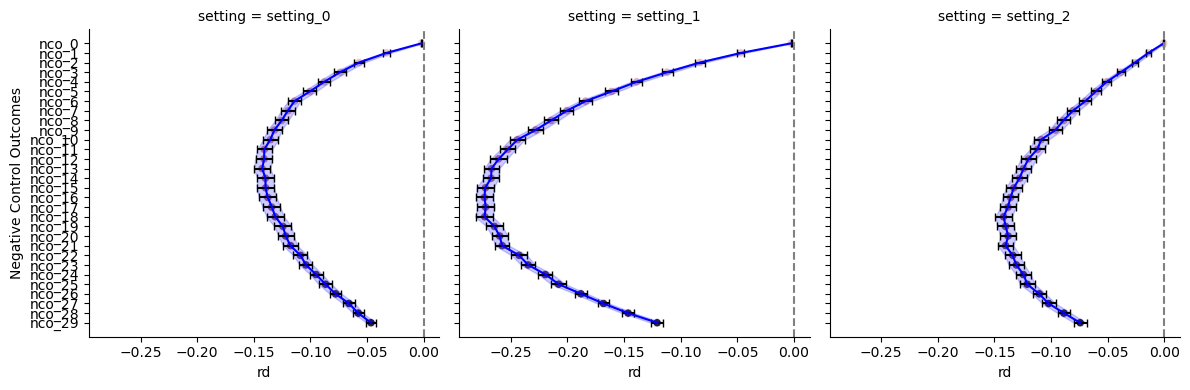

In [16]:
# Function to add error bars
def add_vertical_error_bars(x, y, error, **kwargs):
    data = kwargs.pop("data")
    ax = plt.gca()
    for i, (_, row) in enumerate(data.iterrows()):
        ax.errorbar(row[x], row[y], yerr=1.96*row[error], 
                    fmt='none', ecolor='black', capsize=3)

# for col, data in zip(['rd', 'lrr'], [samps_data, samps_data_lrr]):
for col, data in zip(['rd'], [samps_data]):
    # Initialize a facet grid plot
    g = sns.FacetGrid(data, col='setting', height=4, aspect=1)

    # Create the scatter plot of the simulated data
    g.map(sns.scatterplot, col, 'nco', 'prevalence', alpha=1)

    # Add error bars faceted by 'type'
    g.map_dataframe(add_error_bars, col, 'nco', 'se_'+col)
    g.map(plt.plot, 'avg', 'nco', color='b')
    g.map(plt.fill_betweenx, 'nco', 'low', 'high', color='b', alpha=.2)

    # Rotate x labels
    # [plt.setp(ax.get_xticklabels(), rotation=90) for ax in g.axes.flat]

    # Add verticle line at 0.0
    g.refline(x=0.0)

    # Change x axis label
    g.set_axis_labels(col, "Negative Control Outcomes")

    # # Set ylim
    # g.set(ylim=(-1, 1))

    # Show the plot
    plt.show()